In [1]:
%pylab inline 

import numpy as np
import pandas as pd
import os

import matplotlib as pyplot
import seaborn as sns

import sklearn.metrics

# set context for plot generation
sns.set_context("talk")

# for matplotlib to save pdfs with easy text editing
matplotlib.rcParams['pdf.fonttype'] = 42

save_fig = False
fig_out_dir = '../icml/figures'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# plotting arguments
scale = 8
plot_lw = 4
star_lw = 3
axis_label_fontsize = 28

# Parse data

In [3]:
youtube_data_dir = "../data/youtube_data"

data_file = youtube_data_dir + "/conspiracy_score_VS_youtube_metrics.json"
training_conspiracy_file = youtube_data_dir + "/conspiracy_training.json"
training_nonconspiracy_file = youtube_data_dir + "/non_conspiracy_training.json"

In [4]:
preds = pd.read_json(data_file).dropna().reset_index()
training_1 = pd.read_json(training_conspiracy_file).dropna().reset_index()
training_0 = pd.read_json(training_nonconspiracy_file).dropna().reset_index()

print(len(preds), "total predictions")
print("training sets contain:")
print(len(training_1), " conspiracy videos")
print(len(training_0), " nonconspiracy videos")
print(len(training_1) + len(training_0), " labeled videos")

39817 total predictions
training sets contain:
251  conspiracy videos
290  nonconspiracy videos
541  labeled videos


In [5]:
w_thresh = 1 - np.median(preds['predictions'].values)
p_thresh = 1e5
for df in [preds, training_1, training_0]:
    # add p row
    df['p'] = np.log((1+df['viewCount'].values)/p_thresh)
    df['p_report'] = df['viewCount'].values
    # add w row
    df['w'] = ((1 - df['predictions'].values)  - w_thresh) 
    df['w_report'] = 1 - df['predictions'].values
    
print("w threshold is {0:.2f}".format(w_thresh))
print("{0:.2f} percent of predictions classified as positive welfare".format(np.mean(preds['w'] > 0)))

print("w threshold is {0}".format(p_thresh))
print("{0:.2f} percent of predictions classified as positive profit".format(np.mean(preds['p'] > 0)))

w threshold is 0.95
0.50 percent of predictions classified as positive welfare
w threshold is 100000.0
0.68 percent of predictions classified as positive profit


# Plot distribution of scores and labels

preds
training_0
training_1


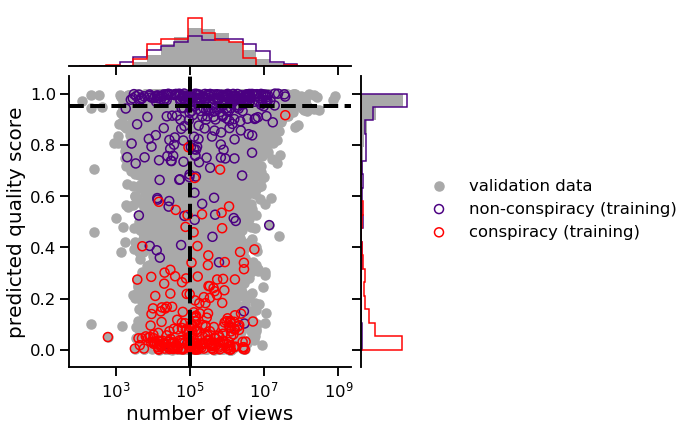

In [6]:
preds['set'] = 'preds'
training_1['set'] = 'training_1'
training_0['set'] = 'training_0'
df_train = pd.concat([training_0,training_1])
df_concat = pd.concat([preds,training_0,training_1])


x_vals = np.log(df_concat['p_report'])
mybins_x =np.logspace(2,9,20)
mybins_y =np.linspace(0,1.0,20)

g = sns.JointGrid(x='p_report',y='w_report',data=df_concat)

colors = {'preds': "darkgray",
         'training_0': 'indigo',
         'training_1': 'red'}

alphas_plot = {'preds': 1.0,
          'training_0': 1.0,
          'training_1': 1.0}

labels = {'preds': 'validation data',
          'training_0': "non-conspiracy (training)",
          'training_1': "conspiracy (training)"}


outlines_only = {'preds': False,
          'training_0': True,
          'training_1': True}

ms = {'preds': 'o',
          'training_0': 'o',
          'training_1': 'o'}



# plotting solution from https://stackoverflow.com/questions/35920885/how-to-overlay-a-seaborn-jointplot-with-a-marginal-distribution-histogram-fr/36001780
def colored_scatter(x, y, c=None, alpha=1.0,label=None, outline_only=False,m='s'):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                if outline_only:
                    kwargs['facecolors']= 'none'
                    kwargs['edgecolors'] = c
                else:
                    kwargs['c'] = c
            kwargs['alpha'] = alpha
            kwargs['label'] = label
            kwargs['marker'] = m
            plt.scatter(*args,**kwargs)
            
        return scatter
    
for name, df_group in df_concat.groupby('set'):
    
    outline = outlines_only[name]
    if outline:
        histtype='step'
        edgecolor=colors[name]
    else:
        histtype='bar'
        

    print(name)
    g.plot_joint(
            colored_scatter(df_group['p_report'],df_group['w_report'],
                            c = colors[name],alpha = alphas_plot[name],label=labels[name],
                            m = ms[name],
                           outline_only=outline)
        )
#g = g.plot_joint(plt.scatter(x=preds['p_report']/1000,y=preds['w_report']),color='C3')
#g.plot_joint(plt.scatter(training_1['p_report'],training_1['w_report']))

    g.ax_marg_x.hist(
        df_group['p_report'],
        color = colors[name],
        alpha = alphas_plot[name],
        bins=mybins_x,
        weights=np.ones(len(df_group))/len(df_group),
        histtype=histtype
        )
    
    g.ax_marg_y.hist(
        df_group['w_report'] ,
        orientation = 'horizontal',
        color = colors[name],
        alpha = alphas_plot[name],
        bins=mybins_y,
        weights=np.ones(len(df_group))/len(df_group),
        histtype=histtype
        )

ax_main = g.ax_joint

tick_locs = np.logspace(3,9,num=4,base=10)

ax_main.set_xscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_x.set_xticks(tick_locs)

ax_main.set_xlabel("number of views",fontsize =20)
ax_main.set_ylabel("predicted quality score", fontsize = 20)

ax_main.axhline(w_thresh, color='black', ls="--",lw=4)

ax_main.axvline(p_thresh, color='black', ls="--",lw=4)

plt.legend(bbox_to_anchor=(1.2,0.7), frameon=False)

if save_fig:
    fig_file = os.path.join(fig_out_dir, "youtube_data_dist_labels.pdf")
    plt.savefig(fig_file, bbox_inches='tight')

# Trace predicted empirical froniter

In [7]:
def decision_rule(alpha, sw, sp):
    assert alpha <= 1
    assert alpha >=0 
    weighted_score = alpha*sw + (1-alpha)*sp
    return weighted_score > 0

def alpha_to_decision(alpha,w,p):
    weighted_scores = alpha*w + (1-alpha)*p
    return np.where(weighted_scores >= 0)[0]


def plot_from_alpha(alpha, w, p, w_offset=0, ax=None,s=None):
    all_idxs = np.arange(len(w))
    idxs_chosen = alpha_to_decision(alpha,w,p)

    idxs_not_chosen = np.delete(np.arange(len(w)),idxs_chosen)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
        
    w_reset = w + w_offset
    ax.scatter(p[idxs_not_chosen], w_reset[idxs_not_chosen], color="grey", s=s)
    ax.scatter(p[idxs_chosen], w_reset[idxs_chosen], color="orange", s=s)
    ax.axhline(w_offset, color="black",alpha=0.5)
    ax.axvline(0, color="black",alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


In [8]:
# augment the training counts
df_train['label_conspiracy'] = df_train.apply(lambda row: int(row['set'] == 'training_1'), axis=1)
df_train['label_quality'] = df_train.apply(lambda row: int(row['set'] == 'training_0'), axis=1)

In [9]:
# alpha plot pareto curves for perfect case

alphas_scan = np.linspace(0,1.0,num=1001)
sums_w_pred = np.zeros_like(alphas_scan)
sums_p_pred = np.zeros_like(alphas_scan)
avgs_w_pred = np.zeros_like(alphas_scan)
avgs_p_pred = np.zeros_like(alphas_scan)

w_pred = preds['w'].values
w_report = preds['w_report'].values
p_pred = preds['p'].values 
p_report = p_pred

std_w = np.std(w_pred)
std_p = np.std(p_pred)

for i,alpha in enumerate(alphas_scan):
    idxs_chosen_pred_pred = decision_rule(alpha,w_pred/std_w,p_pred/std_p)
    #print(np.average(idxs_chosen_pred_pred))
    sums_w_pred[i] = np.sum(w_report[idxs_chosen_pred_pred])
    sums_p_pred[i] = np.sum(p_report[idxs_chosen_pred_pred])
    avgs_w_pred[i] = np.mean(w_report[idxs_chosen_pred_pred])
    avgs_p_pred[i] = np.mean(p_report[idxs_chosen_pred_pred])

In [10]:
alpha_show_1a = 0.0
idx_show_1a = np.argmin(np.abs(alphas_scan-alpha_show_1a))

alpha_show_1b = 0.05
idx_show_1b = np.argmin(np.abs(alphas_scan-alpha_show_1b))

print("at alpha = {0}, p = {1:.1f} and w = {2:.3f}".format(alpha_show_1a, 
                                                   sums_p_pred[idx_show_1a],
                                                   avgs_w_pred[idx_show_1a]))
print("at alpha = {0}, p = {1:.1f} and w = {2:.3f}".format(alpha_show_1b, 
                                                   sums_p_pred[idx_show_1b],
                                                   avgs_w_pred[idx_show_1b]))
print("a {0:.2f} ({1:.1f} %) gain in welfare for a {2:.2f} ({3:.1f} %) loss in profit".format(
                                                   avgs_w_pred[idx_show_1b] - avgs_w_pred[idx_show_1a],
                                                   100*(avgs_w_pred[idx_show_1b]/avgs_w_pred[idx_show_1a] -1),
                                                   sums_p_pred[idx_show_1a] - sums_p_pred[idx_show_1b],
                                                   100*(1 - sums_p_pred[idx_show_1b]/sums_p_pred[idx_show_1a])
                                ))

alpha_show_2a = 0.8
idx_show_2a = np.argmin(np.abs(alphas_scan-alpha_show_2a))

alpha_show_2b = 0.85
idx_show_2b = np.argmin(np.abs(alphas_scan-alpha_show_2b))

print()
print("at alpha = {0}, p = {1:.1f} and w = {2:.3f}".format(alpha_show_2a, 
                                                   sums_p_pred[idx_show_2a],
                                                   avgs_w_pred[idx_show_2a]))
print("a {0:.2f} ({1:.1f} %) gain in welfare for a {2:.2f} ({3:.1f} %) loss in profit".format(
                                                   avgs_w_pred[idx_show_2b] - avgs_w_pred[idx_show_2a],
                                                   100*(avgs_w_pred[idx_show_2b]/avgs_w_pred[idx_show_2a] -1),
                                                   sums_p_pred[idx_show_2a] - sums_p_pred[idx_show_2b],
                                                   100*(1 - sums_p_pred[idx_show_2b]/sums_p_pred[idx_show_2a])
                                ))      

at alpha = 0.0, p = 52724.4 and w = 0.879
at alpha = 0.05, p = 52662.9 and w = 0.888
a 0.01 (1.1 %) gain in welfare for a 61.42 (0.1 %) loss in profit

at alpha = 0.8, p = 42999.2 and w = 0.968
a 0.00 (0.3 %) gain in welfare for a 2227.76 (5.2 %) loss in profit


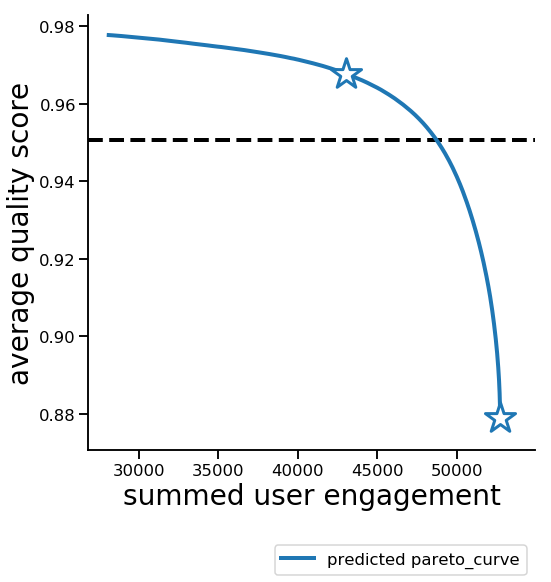

In [11]:
fig, ax = plt.subplots(figsize=(scale, scale))

plt.plot(sums_p_pred,avgs_w_pred,label="predicted pareto_curve",c='C0', lw=plot_lw)

plt.axhline(w_thresh, color="black", ls="--", lw=4,zorder=0)

plt.legend(bbox_to_anchor=(1.0, -0.2))
sns.despine()

plt.scatter([sums_p_pred[idx_show_1a]],[avgs_w_pred[idx_show_1a]],marker='*', 
            s=1000,
            lw = star_lw,
            zorder=3,
            facecolor='white',
            edgecolor='C0')

plt.scatter([sums_p_pred[idx_show_2a]],[avgs_w_pred[idx_show_2a]],marker='*', 
            s=1000,
            lw = star_lw,
            zorder=3,
            facecolor='white',
            edgecolor='C0')

plt.xlabel("summed user engagement", fontsize=axis_label_fontsize)
plt.ylabel("average quality score",fontsize=axis_label_fontsize)

if save_fig:
    fig_file = os.path.join(fig_out_dir, "youtube_pareto.pdf")
    plt.savefig(fig_file, bbox_inches='tight')



# Validate learned policy on labeled data subset

In [12]:
# alpha plot pareto curves for perfect case
#alphas_scan = np.linspace(0,1.0,num=101)
sums_w_pred_01 = np.zeros_like(alphas_scan)
sums_p_pred_01 = np.zeros_like(alphas_scan)
avgs_w_pred_01 = np.zeros_like(alphas_scan)
avgs_p_pred_01 = np.zeros_like(alphas_scan)

sums_w_pred_pred = np.zeros_like(alphas_scan)
sums_p_pred_pred = np.zeros_like(alphas_scan)
avgs_w_pred_pred = np.zeros_like(alphas_scan)
avgs_p_pred_pred = np.zeros_like(alphas_scan)

sums_w_opt = np.zeros_like(alphas_scan)
sums_p_opt = np.zeros_like(alphas_scan)
avgs_w_opt = np.zeros_like(alphas_scan)
avgs_p_opt = np.zeros_like(alphas_scan)

w_pred = df_train['w'].values
w_report_pred = df_train['w_report'].values
w_label = df_train['label_quality'].values - w_thresh
w_report_label = df_train['label_quality'].values

p = df_train['p'].values
p_report = df_train['p_report'].values

std_w = np.std(w_label)
std_p = np.std(p)

for i,alpha in enumerate(alphas_scan):
    idxs_chosen_pred_pred = decision_rule(alpha,w_pred/std_w,p/std_p)
    sums_w_pred_pred[i] = np.sum(w_report_pred[idxs_chosen_pred_pred])
    sums_p_pred_pred[i] = np.sum(p[idxs_chosen_pred_pred])
    avgs_w_pred_pred[i] = np.mean(w_report_pred[idxs_chosen_pred_pred])
    avgs_p_pred_pred[i] = np.mean(p[idxs_chosen_pred_pred])
    
    idxs_chosen_opt = decision_rule(alpha,w_label/std_w,p/std_p)
    sums_w_opt[i] = np.sum(w_report_label[idxs_chosen_opt])
    sums_p_opt[i] = np.sum(p[idxs_chosen_opt])
    avgs_w_opt[i] = np.mean(w_report_label[idxs_chosen_opt])
    avgs_p_opt[i] = np.mean(p[idxs_chosen_opt])
    
    sums_w_pred_01[i] = np.sum(w_report_label[idxs_chosen_pred_pred])
    sums_p_pred_01[i] = np.sum(p[idxs_chosen_pred_pred])
    avgs_w_pred_01[i] = np.mean(w_report_label[idxs_chosen_pred_pred])
    avgs_p_pred_01[i] = np.mean(p[idxs_chosen_pred_pred])

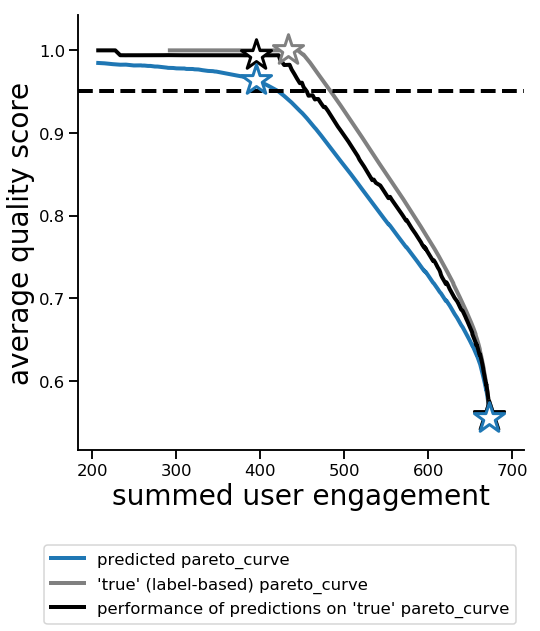

In [13]:
fig, ax = plt.subplots(figsize=(8,8))



plt.plot(sums_p_pred_pred,avgs_w_pred_pred,label="predicted pareto_curve",c='C0', lw=plot_lw)
plt.plot(sums_p_opt,avgs_w_opt,label="'true' (label-based) pareto_curve",c='grey',lw=plot_lw)
plt.plot(sums_p_pred_01,avgs_w_pred_01, label="performance of predictions on 'true' pareto_curve",c='black', 
         lw=plot_lw)


plt.scatter([sums_p_opt[idx_show_1a]],[avgs_w_opt[idx_show_1a]],marker='*', 
            s=1000,
            lw = star_lw,
            zorder=3,
           facecolor='white',
           edgecolor='grey')

plt.scatter([sums_p_pred_01[idx_show_1a]],[avgs_w_pred_01[idx_show_1a]],marker='*', 
            s=1000,
            lw =star_lw,
            zorder=3,
           facecolor='white',
           edgecolor='black')

plt.scatter([sums_p_pred_pred[idx_show_1a]],[avgs_w_pred_pred[idx_show_1a]],marker='*', 
            s=1000,
            lw = star_lw,
            zorder=3,
            facecolor='white',
           edgecolor='C0')

plt.scatter([sums_p_opt[idx_show_2a]],[avgs_w_opt[idx_show_2a]],marker='*', 
            s=1000,
            lw = star_lw,
            zorder=3,
           facecolor='white',
           edgecolor='grey')

plt.scatter([sums_p_pred_01[idx_show_2a]],[avgs_w_pred_01[idx_show_2a]],marker='*', 
            s=1000,
            lw = star_lw,
            zorder=3,
           facecolor='white',
           edgecolor='black')



plt.scatter([sums_p_pred_pred[idx_show_2a]],[avgs_w_pred_pred[idx_show_2a]],marker='*', 
            s=1000,
            lw = 3,
            zorder=3,
            facecolor='white',
           edgecolor='C0')


plt.axhline(w_thresh, color="black", ls="--", lw=4)


sns.despine()

plt.xlabel("summed user engagement", fontsize=axis_label_fontsize) # \n (log(# views /100,000))")
plt.ylabel("average quality score", fontsize=axis_label_fontsize)

plt.legend(bbox_to_anchor=(1.0, -0.2))

if save_fig:
    fig_file = os.path.join(fig_out_dir, "youtube_pareto_with_labels.pdf")
    plt.savefig(fig_file, bbox_inches='tight')

